In [54]:
!pip install opencv-python-headless 


You should consider upgrading via the '/env/bin/python3 -m pip install --upgrade pip' command.


In [126]:
#import required libraries 
%matplotlib inline
#general package 
import os
#for raster analysis 
import numpy as np
import cv2
import matplotlib.pyplot as plt 
import glob 
import rasterio as rio
from rasterio.merge import merge
from rasterio.plot import show
from osgeo import gdal
from skimage.transform import warp 
#for bounding box 
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely.geometry import Polygon
from geopandas import GeoSeries, GeoDataFrame

In [87]:
RImage = gdal.Open('..//Real_world_examples/LCCSlayer/coherence/SYDNEY_velocity.tif', gdal.GA_ReadOnly)
LImage = gdal.Open('..//Real_world_examples/LCCSlayer/coherence/ORANGE_velocity.tif', gdal.GA_ReadOnly)

In [90]:
#Reading each image separately as one band 
band1 = RImage.GetRasterBand(1)
band2 = LImage.GetRasterBand(1) 

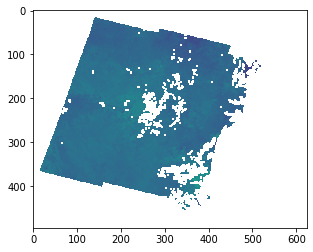

In [173]:
#The way that you can show the image
arr1= band1.ReadAsArray()
arr2 =band2.ReadAsArray()
plt.imshow(arr1)

In [93]:
#function to find the intersection area
def findRasterIntersect(raster1,raster2):
    # load data
    band1 = raster1.GetRasterBand(1)
    band2 = raster2.GetRasterBand(1)
    gt1 = raster1.GetGeoTransform()
    gt2 = raster2.GetGeoTransform()
    
    # find each image's bounding box
    # r1 has left, top, right, bottom of dataset's bounds in geospatial coordinates.
    r1 = [gt1[0], gt1[3], gt1[0] + (gt1[1] * raster1.RasterXSize), gt1[3] + (gt1[5] * raster1.RasterYSize)]
    r2 = [gt2[0], gt2[3], gt2[0] + (gt2[1] * raster2.RasterXSize), gt2[3] + (gt2[5] * raster2.RasterYSize)]
    print ('\t1 bounding box: %s' % str(r1))
    print ('\t2 bounding box: %s' % str(r2))
    
    # find intersection between bounding boxes
    intersection = [max(r1[0], r2[0]), min(r1[1], r2[1]), min(r1[2], r2[2]), max(r1[3], r2[3])]
    if r1 != r2:
        print ('\t** different bounding boxes **')
        # check for any overlap at all...
        if (intersection[2] < intersection[0]) or (intersection[1] < intersection[3]):
            intersection = None
            print ('\t***no overlap***')
            return
        else:
            print ('\tintersection:',intersection)
            left1 = int(round((intersection[0]-r1[0])/gt1[1])) # difference divided by pixel dimension
            top1 = int(round((intersection[1]-r1[1])/gt1[5]))
            col1 = int(round((intersection[2]-r1[0])/gt1[1])) - left1 # difference minus offset left
            row1 = int(round((intersection[3]-r1[1])/gt1[5])) - top1
            
            left2 = int(round((intersection[0]-r2[0])/gt2[1])) # difference divided by pixel dimension
            top2 = int(round((intersection[1]-r2[1])/gt2[5]))
            col2 = int(round((intersection[2]-r2[0])/gt2[1])) - left2 # difference minus new left offset
            row2 = int(round((intersection[3]-r2[1])/gt2[5])) - top2
            
            #print '\tcol1:',col1,'row1:',row1,'col2:',col2,'row2:',row2
            if col1 != col2 or row1 != row2:
                print ("*** MEGA ERROR *** COLS and ROWS DO NOT MATCH ***")
            # these arrays should now have the same spatial geometry though NaNs may differ
            array1 = band1.ReadAsArray(left1,top1,col1,row1)
            array2 = band2.ReadAsArray(left2,top2,col2,row2)

    else: # same dimensions from the get go
        col1 = raster1.RasterXSize # = col2
        row1 = raster1.RasterYSize # = row2
        array1 = band1.ReadAsArray()
        array2 = band2.ReadAsArray()
        
    return array1, array2, col1, row1, intersection

In [95]:
#call the intersection function to assess 
#this will result in subset array for image 1 and image2, the number of columns and rows in the intersection and the geographic bounding box (LURB)
#the bounding box for intrsected area can then be used as a bounding box for query coherence 
image1_isect_array, image2_isect_array, col,row,isect_bb = findRasterIntersect(RImage,LImage)

	1 bounding box: [148.59041681111, -32.67847251111, 152.05708350551, -35.43402808871]
	2 bounding box: [146.95208351111, -32.02513911111, 150.20763909271, -34.28069468471]
	** different bounding boxes **
	intersection: [148.59041681111, -32.67847251111, 150.20763909271, -34.28069468471]


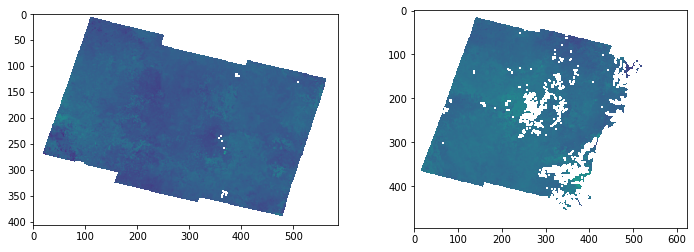

In [230]:
#create four plots next to each other 
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

# Plot first four files
show(arr2, ax=ax1)
show(arr1, ax=ax2)

# Do not show y-ticks values in last three axis
for ax in [ax1]:
    ax.yaxis.set_visible(True)

In [231]:
xy = np.array([[150,200],[200,200],[150,100],[250,150]])

In [232]:
#xaya = np.array([[400,200],[500,150],[450,150],[500,200]])
xaya = np.array([[150,200],[200,200],[150,100],[200,180]])

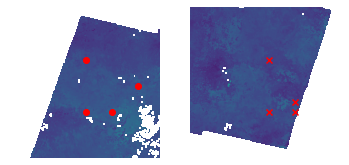

In [233]:
plt.subplot(121);plt.imshow(image1_isect_array);plt.axis('off')
plt.scatter(xy[:,0],xy[:,1],marker='o',color='r');

plt.subplot(122);plt.imshow(image2_isect_array);plt.axis('off')
plt.scatter(xaya[:,0],xaya[:,1],marker='x',color='r');
plt.show()

In [234]:
P= cv2.getPerspectiveTransform(xy.astype(np.float32),xaya.astype(np.float32))

In [235]:
print (P)

[[-3.69230769e+00  9.23076923e-01  3.23076923e+02]
 [-3.38461538e+00  3.07692308e-01  3.84615385e+02]
 [-1.69230769e-02  6.15384615e-03  1.00000000e+00]]


In [240]:
f_stitched = warp(image2_isect_array,P,output_shape=(500,500))

In [241]:
M,N = image1_isect_array.shape[:2]

In [242]:
f_stitched[0:M, 0:N] = image1_isect_array

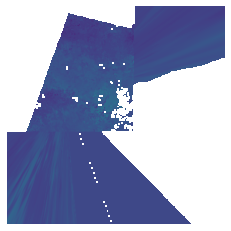

In [243]:
plt.imshow(f_stitched);plt.axis('off')
plt.show()

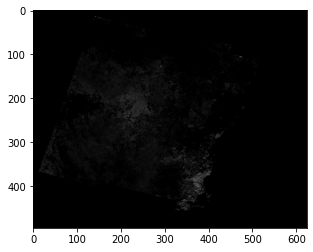

In [75]:
f = plt.imread('..//Real_world_examples/LCCSlayer/coherence/SYDNEY_velocity.tif')
fcv2 = f[:,:,::-1]
plt.imshow(f);

In [77]:
image1_ds = gdal.Open('..//Real_world_examples/LCCSlayer/coherence/SYDNEY_velocity.tif')

In [51]:
RImage = np.array([[100,300]])

In [52]:
RImage[:,1]

array([300])

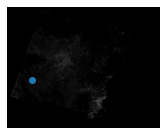

In [53]:
plt.subplot(121); plt.imshow(f); plt.axis('off');
plt.scatter(RImage[:,0],RImage[:,1], marker='o');

In [9]:
sift2 = cv2.xfeatures2d.SIFT_create()

AttributeError: module 'cv2.cv2' has no attribute 'xfeatures2d'

In [4]:
min_match_count = 10

In [5]:
img1 = cv2.imread('..//Real_world_examples/LCCSlayer/coherence/SYDNEY_velocity.tif',0)
img2 = cv2.imread('..//Real_world_examples/LCCSlayer/coherence/ORANGE_velocity.tif',0)

In [6]:
#initiate SIFT detector 
sift = cv2.SIFT()

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

In [ ]:
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

In [1]:
flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

NameError: name 'cv2' is not defined

In [1]:
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

NameError: name 'matches' is not defined

In [1]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print (len(good),MIN_MATCH_COUNT)
    matchesMask = None

NameError: name 'good' is not defined

(-0.5, 623.5, 495.5, -0.5)

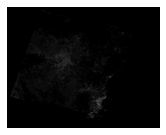

In [4]:
plt.subplot(121);plt.imshow(f1);plt.axis('off')
#plt.subplot(122);plt.imshow(f2);plt.axis('off')

In [7]:
# fig, ax = plt.subplots(figsize = (8,7))
# ax.scatter(df.longitude, df.latitude, zorder=1, alpha= 0.2, c='b', s=10)
# ax.set_title('Plotting Spatial Data on Map')
# ax.set_xlim(BBox[0],BBox[1])
# ax.set_ylim(BBox[2],BBox[3])
# ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

In [8]:
#selected points in right image 
RImage = np.array([[149.219,33.71],
                  [149.64,33.31]])
    
#RImage = np.array([[149.64,33.31]])
#selected points in left image
#LImage = np.array([[149.219,33.71],
                  # [149.64,33.31]])

In [9]:
len(RImage)

2

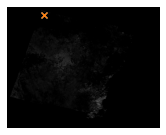

In [10]:
plt.subplot(121); plt.imshow(f1); plt.axis('off');

plt.scatter(RImage[0,0], RImage[0,1], marker='x');
plt.scatter(RImage[1,0], RImage[1,1], marker='x');

# plt.subplot(122); plt.imshow(f2); plt.axis('off');

# plt.scatter(LImage[:,0], LImage[:,1], marker='x');

plt.show()

In [14]:
import cv2
import numpy as np

img = cv2.imread('1original.jpg',0)

src = np.array([[50,50],[450,450],[70,420],[420,70]],np.float32)
dst = np.array([[0,0],[299,299],[0,299],[299,0]],np.float32)

ret = cv2.getPerspectiveTransform(src,dst)
print (ret)

[[ 8.36097696e-01 -4.51944700e-02 -3.95451613e+01]
 [-4.51944700e-02  8.36097696e-01 -3.95451613e+01]
 [ 6.45161290e-05  6.45161290e-05  1.00000000e+00]]


In [12]:
P = cv2.getPerspectiveTransform(RImage.astype(np.float32), LImage.astype(np.float32))
print(P)

error: OpenCV(4.5.1) /tmp/pip-req-build-_a0ur5ao/opencv/modules/imgproc/src/imgwarp.cpp:3392: error: (-215:Assertion failed) src.checkVector(2, CV_32F) == 4 && dst.checkVector(2, CV_32F) == 4 in function 'getPerspectiveTransform'


In [ ]:
In [17]: f_stitched = warp(f2, P, output_shape=(300,450))

In [18]: M, N = f1.shape[:2]

In [19]: f_stitched[0:M, 0:N, :] = f1

In [20]: plt.imshow(f_stitched); plt.axis('off')
Out[20]: (-0.5, 449.5, 299.5, -0.5)

In [21]: plt.show()

In [3]:
#pip install opencv-python-headless

In [8]:
#setting a search criteria for all tiff files that we want to use 
dirpath = '..//Real_world_examples/LCCSlayer/coherence'
outfp= '..//Real_world_examples/LCCSlayer/coherence/mosaic.tif'
#Search criteria
search_criteria = "*_velocity.tif"
q = os.path.join(dirpath,search_criteria)
print(q)

..//Real_world_examples/LCCSlayer/coherence/*_velocity.tif


In [9]:
#listing all the files with searching criteria 
velocity_ftp = glob.glob(q)
velocity_ftp

['..//Real_world_examples/LCCSlayer/coherence/SYDNEY_velocity.tif',
 '..//Real_world_examples/LCCSlayer/coherence/ORANGE_velocity.tif']

In [10]:
#create an empty list for all datafiles that is going to be part of mosaic 
velocity_src_files = []

In [11]:
for fp in velocity_ftp:
    src = rasterio.open(fp)
    velocity_src_files.append(src)
velocity_src_files

[<open DatasetReader name='..//Real_world_examples/LCCSlayer/coherence/SYDNEY_velocity.tif' mode='r'>,
 <open DatasetReader name='..//Real_world_examples/LCCSlayer/coherence/ORANGE_velocity.tif' mode='r'>]

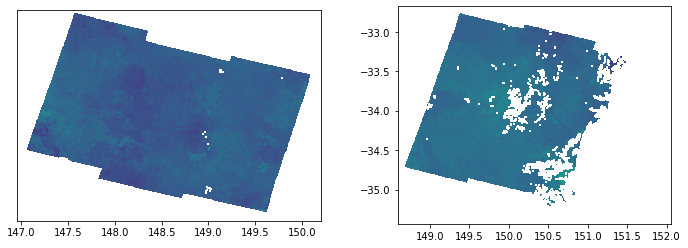

In [12]:
#create four plots next to each other 
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))

# Plot first four files
show(velocity_src_files[1], ax=ax1)
show(velocity_src_files[0], ax=ax2)

# Do not show y-ticks values in last three axis
for ax in [ax1]:
    ax.yaxis.set_visible(False)

In [13]:
#merge function returns a single mosaic array and the transformation info 
mosaic, out_trans = merge(velocity_src_files)

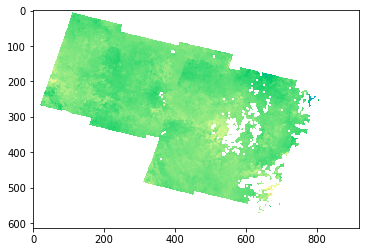

In [14]:
show(mosaic, cmap='terrain')

In [43]:
#Copy and update the metadata 
out_meta = src.meta.copy()
out_meta.update({"driver":"GTiff",
                "height":mosaic.shape[1],
                "Width":mosaic.shape[2],
                "transform":out_trans})

In [45]:
#Saving the mosaic file out 
with rasterio.open(outfp,"w",**out_meta) as dest:
    dest.write(mosaic)